In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set("talk")

def std_err(x):
    return x.std() / np.sqrt(len(x))

In [2]:
df = pd.read_csv("../data/synthetic_results.csv")

outcome_cols = ['regression_outcome', 'career_outcome', 'dragonnet_outcome',
                'projection_outcome', 'r_learner_outcome']
aipw_cols = ['regression_aipw', 'career_aipw', 'dragonnet_aipw',
             'projection_aipw']
mse_cols = ['regression_mse', 'career_mse', 'dragonnet_mse', 'projection_mse']
nll_cols = ['regression_nll', 'career_nll', 'dragonnet_nll', 'projection_nll']

# Create error columns for each outcome estimate
for col in outcome_cols + aipw_cols:
    error_col_name = f'{col}_error'
    df[error_col_name] = (df[col] - df['treatment_effect']) ** 2

for col in outcome_cols:
    df[f'{col}_improvement'] = df['career_outcome_error'] - df[f'{col}_error']

for col in aipw_cols:
    df[f'{col}_improvement'] = df['career_aipw_error'] - df[f'{col}_error']



In [3]:
methods = ['dragonnet_outcome', 'projection_outcome', 'r_learner_outcome']
method_to_label = {'dragonnet_outcome': 'Multi-task fine-tuning',
                   'projection_outcome': 'Projection fine-tuning',
                    'r_learner_outcome': 'Difference-based fine-tuning',
}

In [4]:
results = {
    'shared_proportion': {},
    'treatment_effect': {},
    'noise_scale': {}
}

shared_proportion_stats = df.groupby('shared_proportion').agg({
    'dragonnet_outcome_improvement': ['mean', std_err],
    'projection_outcome_improvement': ['mean', std_err],
    'r_learner_outcome_improvement': ['mean', std_err]
})

# For shared_proportion
for method in methods:
    results['shared_proportion'][method] = {
        'mean': shared_proportion_stats[(f'{method}_improvement', 'mean')].values,
        'std': shared_proportion_stats[(f'{method}_improvement', 'std_err')].values,
        'group': shared_proportion_stats.index.values
    }

# For treatment_effect
treatment_stats = df.groupby('treatment_effect').agg({
    'dragonnet_outcome_improvement': ['mean', std_err],
    'projection_outcome_improvement': ['mean', std_err],
    'r_learner_outcome_improvement': ['mean', std_err]
})

for method in methods:
    results['treatment_effect'][method] = {
        'mean': treatment_stats[(f'{method}_improvement', 'mean')].values,
        'std': treatment_stats[(f'{method}_improvement', 'std_err')].values,
        'group': treatment_stats.index.values
    }

# For noise_scale
noise_stats = df.groupby('noise_scale').agg({
    'dragonnet_outcome_improvement': ['mean', std_err],
    'projection_outcome_improvement': ['mean', std_err],
    'r_learner_outcome_improvement': ['mean', std_err]
})

for method in methods:
    results['noise_scale'][method] = {
        'mean': noise_stats[(f'{method}_improvement', 'mean')].values,
        'std': noise_stats[(f'{method}_improvement', 'std_err')].values,
        'group': noise_stats.index.values
    }

#### The data used in the next cell makes Figure 1

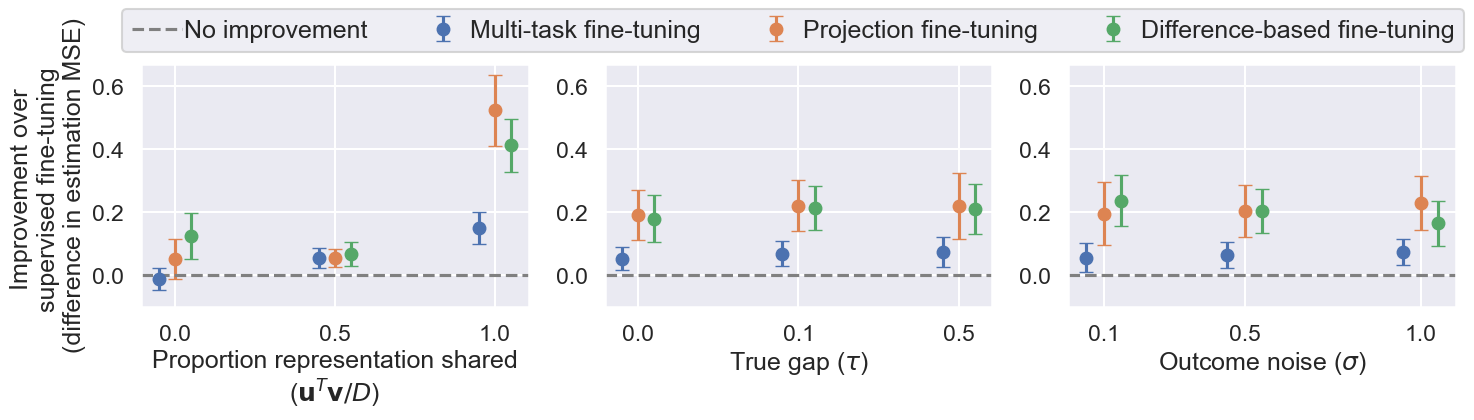

In [5]:

sns.set("talk")
# fig, axs = plt.subplots(figsize=(15, 4.9), nrows=1, ncols=3)
fig, axs = plt.subplots(figsize=(15, 4), nrows=1, ncols=3)
ax1, ax2, ax3 = axs.flatten()

offsets = [-0.05, 0, 0.05]

ylim_min = -0.1
ylim_max = 0.67

category = 'shared_proportion'
for i, method in enumerate(methods):
  means = results[category][method]['mean']
  stds = results[category][method]['std']
  group = results[category][method]['group']
  ax1.errorbar(np.array(group) + offsets[i], means, yerr=2*stds, fmt='o', capsize=5, label=method_to_label[method])
ax1.axhline(0, color='gray', linestyle='--', label='No improvement')
ax1.set_xlabel("Proportion representation shared\n($\mathbf{u}^T \mathbf{v}/D$)")
ax1.set_ylabel("Improvement over \nsupervised fine-tuning \n(difference in estimation MSE)")#, fontsize=20)
ax1.set_ylim(ylim_min, ylim_max)
ax1.set_xticks(np.array(group))
# ax1.legend(fontsize=15.5, bbox_to_anchor=(0., -.33), loc='upper left')
# ax1.legend(fontsize=14, loc='upper left')

category = 'treatment_effect'
for i, method in enumerate(methods):
  means = results[category][method]['mean']
  stds = results[category][method]['std']
  group = results[category][method]['group']
  ax2.errorbar(np.array([0, 1, 2]) + 2*offsets[i], means, yerr=2*stds, fmt='o', capsize=5)#, label=method_to_label[method])
  # ax2.errorbar(np.array(group), means, yerr=2*stds, fmt='o', capsize=5, label=method_to_label[method])
ax2.axhline(0, color='gray', linestyle='--')#, label='No improvement')
ax2.set_xlabel(r"True gap ($\tau$)")
ax2.set_xticks(np.array([0, 1, 2]))
# ax2.set_xticklabels(['None', 'Small', 'Large'])
ax2.set_xticklabels(group)
ax2.set_ylim(ylim_min, ylim_max)
# ax2.legend(loc='upper left', fontsize=14)

category = 'noise_scale'
for i, method in enumerate(methods):
  means = results[category][method]['mean']
  stds = results[category][method]['std']
  group = results[category][method]['group']
  ax3.errorbar(np.array(group) + offsets[i], means, yerr=2*stds, fmt='o', capsize=5)#, label=method_to_label[method])
ax3.axhline(0, color='gray', linestyle='--')#, label='No improvement')
ax3.set_xlabel("Outcome noise ($\sigma$)")
ax3.set_ylim(ylim_min, ylim_max)
ax3.set_xticks(np.array(group))
# ax3.legend(loc='upper left', fontsize=14)

fig.tight_layout()
# fig.legend(loc='upper center', bbox_to_anchor=(0.54, 1.1), ncol=4, fontsize=17)
# fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, fontsize=18)
fig.legend(loc='upper center', bbox_to_anchor=(0.54, 1.1), ncol=4, fontsize=18, handletextpad=0.1)
plt.savefig("../figs/semi_synthetic_three_panel.pdf", bbox_inches='tight', dpi=300)

In [6]:
aipw_methods = ['dragonnet_aipw', 'projection_aipw', 'r_learner_outcome']
method_to_label = {'r_learner_outcome': 'Difference-based fine-tuning (outcome-only estimator)',
                    'dragonnet_aipw': 'Multi-task fine-tuning (AIPW estimator)',
                    'projection_aipw': 'Projection fine-tuning (AIPW estimator)',}

In [7]:
results_aipw = {
    'shared_proportion': {},
    'treatment_effect': {},
    'noise_scale': {}
}

shared_proportion_stats = df.groupby('shared_proportion').agg({
    'dragonnet_aipw_improvement': ['mean', std_err],
    'projection_aipw_improvement': ['mean', std_err],
    'r_learner_outcome_improvement': ['mean', std_err]
})

# For shared_proportion
for method in aipw_methods:
    results_aipw['shared_proportion'][method] = {
        'mean': shared_proportion_stats[(f'{method}_improvement', 'mean')].values,
        'std': shared_proportion_stats[(f'{method}_improvement', 'std_err')].values,
        'group': shared_proportion_stats.index.values
    }

# For treatment_effect
treatment_stats = df.groupby('treatment_effect').agg({
    'dragonnet_aipw_improvement': ['mean', std_err],
    'projection_aipw_improvement': ['mean', std_err],
    'r_learner_outcome_improvement': ['mean', std_err]
})

for method in aipw_methods:
    results_aipw['treatment_effect'][method] = {
        'mean': treatment_stats[(f'{method}_improvement', 'mean')].values,
        'std': treatment_stats[(f'{method}_improvement', 'std_err')].values,
        'group': treatment_stats.index.values
    }

# For noise_scale
noise_stats = df.groupby('noise_scale').agg({
    'dragonnet_aipw_improvement': ['mean', std_err],
    'projection_aipw_improvement': ['mean', std_err],
    'r_learner_outcome_improvement': ['mean', std_err]
})

for method in aipw_methods:
    results_aipw['noise_scale'][method] = {
        'mean': noise_stats[(f'{method}_improvement', 'mean')].values,
        'std': noise_stats[(f'{method}_improvement', 'std_err')].values,
        'group': noise_stats.index.values
    }

#### The data used in the next cell makes Figure S1

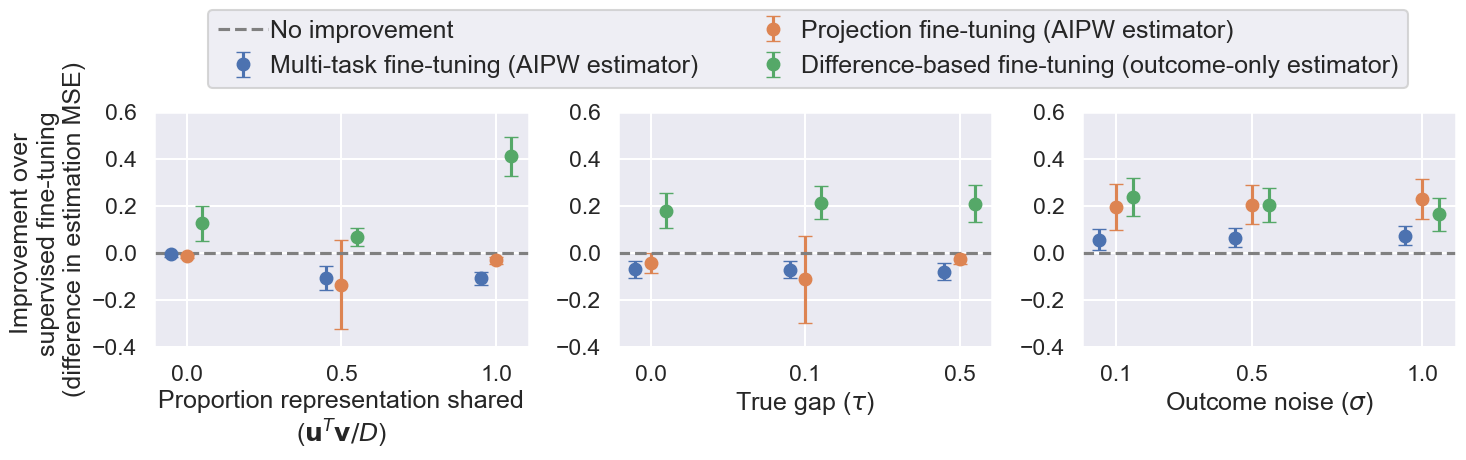

In [8]:

sns.set("talk")
fig, axs = plt.subplots(figsize=(15, 4), nrows=1, ncols=3)
ax1, ax2, ax3 = axs.flatten()

offsets = [-0.05, 0, 0.05]

ylim_min = -0.4
ylim_max = 0.6

category = 'shared_proportion'
for i, method in enumerate(aipw_methods):
  means = results_aipw[category][method]['mean']
  stds = results_aipw[category][method]['std']
  group = results_aipw[category][method]['group']
  ax1.errorbar(np.array(group) + offsets[i], means, yerr=2*stds, fmt='o', capsize=5, label=method_to_label[method])
ax1.axhline(0, color='gray', linestyle='--', label='No improvement')
ax1.set_xlabel("Proportion representation shared\n($\mathbf{u}^T \mathbf{v}/D$)")
ax1.set_ylabel("Improvement over \nsupervised fine-tuning \n(difference in estimation MSE)")#, fontsize=20)
ax1.set_ylim(ylim_min, ylim_max)
ax1.set_xticks(np.array(group))

category = 'treatment_effect'
for i, method in enumerate(aipw_methods):
  means = results_aipw[category][method]['mean']
  stds = results_aipw[category][method]['std']
  group = results_aipw[category][method]['group']
  ax2.errorbar(np.array([0, 1, 2]) + 2*offsets[i], means, yerr=2*stds, fmt='o', capsize=5)#, label=method_to_label[method])
ax2.axhline(0, color='gray', linestyle='--')#, label='No improvement')
ax2.set_xlabel(r"True gap ($\tau$)")
ax2.set_xticks(np.array([0, 1, 2]))
ax2.set_xticklabels(group)
ax2.set_ylim(ylim_min, ylim_max)

category = 'noise_scale'
for i, method in enumerate(methods):
  means = results[category][method]['mean']
  stds = results[category][method]['std']
  group = results[category][method]['group']
  ax3.errorbar(np.array(group) + offsets[i], means, yerr=2*stds, fmt='o', capsize=5)#, label=method_to_label[method])
ax3.axhline(0, color='gray', linestyle='--')#, label='No improvement')
ax3.set_xlabel("Outcome noise ($\sigma$)")
ax3.set_ylim(ylim_min, ylim_max)
ax3.set_xticks(np.array(group))

fig.tight_layout()
fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.2), ncol=2, fontsize=18, handletextpad=0.1)
plt.savefig("../figs/semi_synthetic_three_panel_aipw.pdf", bbox_inches='tight', dpi=300)

### Evaluation metrics

In [9]:
# Create dictionary to store results
r_learner_results = {
    'shared_proportion': {},
    'treatment_effect': {},
    'noise_scale': {}
}

# Function to calculate correlation and std error using bootstrap
def corr_with_std_err(group, cal_cols, err_cols, n_bootstrap=100):
    unflattened_calibration_errors = group[cal_cols].values
    unflattened_outcome_errors = group[err_cols].values
    base_corr = np.mean([np.corrcoef(unflattened_calibration_errors[i], unflattened_outcome_errors[i])[0, 1] for i in range(len(unflattened_calibration_errors))])  # 0.329 for square, 0.468 for abs
    bootstrap_corrs = []
    for _ in range(n_bootstrap):
        indices = np.random.choice(len(group), size=len(group), replace=True)
        bootstrap_sample = group.iloc[indices]
        unflattened_calibration_errors = bootstrap_sample[cal_cols].values
        unflattened_outcome_errors = bootstrap_sample[err_cols].values
        bootstrap_corr = np.mean([np.corrcoef(unflattened_calibration_errors[i], unflattened_outcome_errors[i])[0, 1] for i in range(len(unflattened_calibration_errors))])
        bootstrap_corrs.append(bootstrap_corr)
    return base_corr, np.std(bootstrap_corrs)

categories = ['shared_proportion', 'treatment_effect', 'noise_scale']

for category in categories:
        cal_cols = ['regression_abs_calibration_error', 'career_abs_calibration_error', 'dragonnet_abs_calibration_error', 'projection_abs_calibration_error', 'r_learner_abs_calibration_error']
        err_cols = ['regression_outcome_error', 'career_outcome_error', 'dragonnet_outcome_error', 'projection_outcome_error', 'r_learner_outcome_error']
        r_learner_cols = ['regression_rl_obj', 'career_rl_obj', 'dragonnet_rl_obj', 'projection_rl_obj', 'r_learner_rl_obj']
        # Group by category and calculate correlations
        grouped_stats_r_learner = df.groupby(category).apply(
            lambda x: pd.Series({
                'mean': corr_with_std_err(x, r_learner_cols, err_cols)[0],
                'std': corr_with_std_err(x, r_learner_cols, err_cols)[1],
            })
        )
        r_learner_results[category] = {
            'mean': grouped_stats_r_learner['mean'].values,
            'std': grouped_stats_r_learner['std'].values,
            'group': grouped_stats_r_learner.index.values
        }

#### The data used in the next cell makes Figure S2

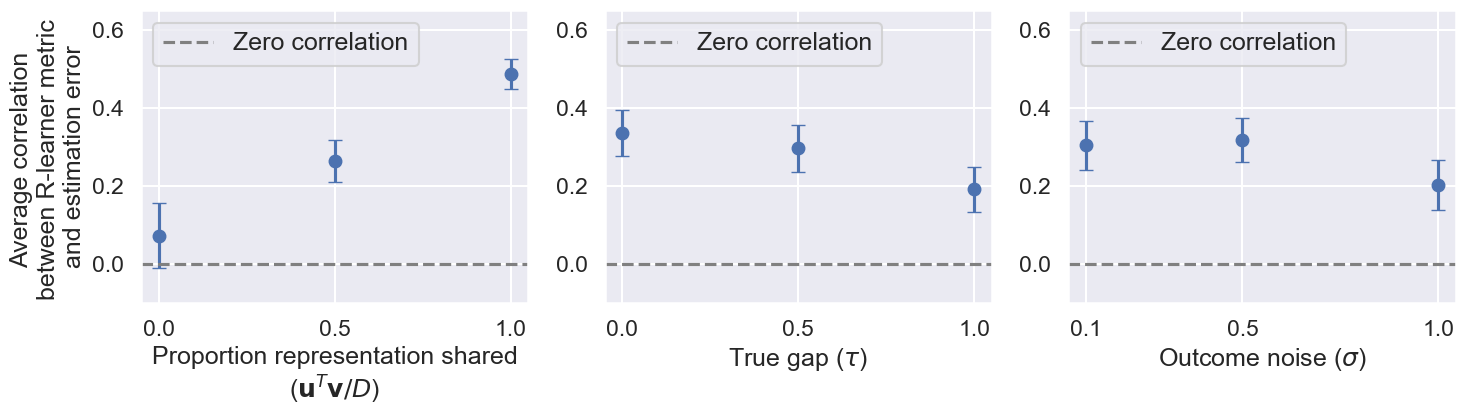

In [10]:

sns.set("talk")
fig, axs = plt.subplots(figsize=(15, 4.5), nrows=1, ncols=3)
ax1, ax2, ax3 = axs.flatten()

offsets = [0.]

ylim_min = -0.1
ylim_max = 0.65

category = 'shared_proportion'
for i, method in enumerate([r_learner_results,]):
  means = method[category]['mean']
  stds = method[category]['std']
  group = method[category]['group']
  # label = 'Calibration of differences' if i == 0 else 'Residual objective'
  ax1.errorbar(np.array(group) + offsets[i], means, yerr=stds, fmt='o', capsize=5)#, label=label)
ax1.axhline(0, color='gray', linestyle='--', label='Zero correlation')
ax1.set_xlabel("Proportion representation shared\n($\mathbf{u}^T \mathbf{v}/D$)")
ax1.set_ylabel("Average correlation \nbetween R-learner metric \nand estimation error")
ax1.set_ylim(ylim_min, ylim_max)
ax1.set_xticks(np.array(group))
ax1.legend(loc='upper left', fontsize=18)

category = 'treatment_effect'
for i, method in enumerate([r_learner_results]):
  means = method[category]['mean']
  stds = method[category]['std']
  ax2.errorbar(np.array([0, 1, 2]) + offsets[i], means, yerr=stds, fmt='o', capsize=5)#, label=method_to_label[method])
ax2.axhline(0, color='gray', linestyle='--', label='Zero correlation')
ax2.set_xlabel(r"True gap ($\tau$)")
ax2.set_xticks(np.array([0, 1, 2]))
ax2.set_xticklabels(group)
ax2.legend(loc='upper left', fontsize=18)

ax2.set_ylim(ylim_min, ylim_max)


category = 'noise_scale'
for i, method in enumerate([r_learner_results]):
  means = method[category]['mean']
  stds = method[category]['std']
  group = method[category]['group']
  ax3.errorbar(np.array(group) + offsets[i], means, yerr=stds, fmt='o', capsize=5)#, label=method_to_label[method])
ax3.axhline(0, color='gray', linestyle='--', label='Zero correlation')
ax3.set_xlabel("Outcome noise ($\sigma$)")
ax3.set_ylim(ylim_min, ylim_max)
ax3.set_xticks(np.array(group))
ax3.legend(loc='upper left', fontsize=18)
# fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.1), fontsize=18, handletextpad=0.1)

fig.tight_layout()
plt.savefig("../figs/evaluation_metrics_semi_synthetic.pdf", bbox_inches='tight', dpi=300)

### Get big table of results

In [11]:
# Define the columns we want to analyze
improvement_cols = ['regression_outcome_improvement', 'dragonnet_outcome_improvement', 
                   'projection_outcome_improvement', 'r_learner_outcome_improvement']

# Group by all three parameters and calculate means and standard errors
grouped_stats = df.groupby(['treatment_effect', 'shared_proportion', 'noise_scale'])[improvement_cols].agg(['mean', 'std'])
# grouped_stats = df.groupby(['treatment_effect', 'shared_proportion', 'noise_scale'])[improvement_cols].agg(['mean'])

# Reset index to make it easier to work with
grouped_stats = grouped_stats.reset_index()
# Reshape the DataFrame to be more readable
clean_results = pd.DataFrame()
clean_results['treatment_effect'] = grouped_stats['treatment_effect']
clean_results['shared_proportion'] = grouped_stats['shared_proportion']
clean_results['noise_scale'] = grouped_stats['noise_scale']

for col in improvement_cols:
    clean_results[f'{col}_mean'] = grouped_stats[(col, 'mean')]
    clean_results[f'{col}_std'] = grouped_stats[(col, 'std')]


In [12]:
# Calculate correlation for each row/experiment
df['rl_error_correlation'] = df.apply(lambda row: np.corrcoef(
    [row['regression_rl_obj'], row['career_rl_obj'], row['dragonnet_rl_obj'], 
     row['projection_rl_obj'], row['r_learner_rl_obj']],
    [row['regression_outcome_error'], row['career_outcome_error'], row['dragonnet_outcome_error'],
     row['projection_outcome_error'], row['r_learner_outcome_error']]
)[0,1], axis=1)

#### The data used in the next cell makes Table S6

In [13]:
# Define the columns we want to analyze
improvement_cols = ['regression_outcome_improvement', 'dragonnet_outcome_improvement', 
                   'projection_outcome_improvement', 'r_learner_outcome_improvement',
                   'rl_error_correlation']

# Group by all three parameters and calculate means and standard errors
grouped_stats = df.groupby(['treatment_effect', 'shared_proportion', 'noise_scale'])[improvement_cols].agg(['mean', 'std'])

# Reset index to make it easier to work with
grouped_stats = grouped_stats.reset_index()

# Format the column names to be more readable in LaTeX
column_mapping = {
    'treatment_effect': 'Treatment Effect',
    'shared_proportion': 'Shared Proportion',
    'noise_scale': 'Noise Scale',
    'regression_outcome_improvement': 'Regression',
    'dragonnet_outcome_improvement': 'Multi-task',
    'projection_outcome_improvement': 'Projection',
    'r_learner_outcome_improvement': 'Difference',
    'rl_error_correlation': 'R-learner Correlation'
}

# Create new DataFrame with combined mean and std
clean_results_latex = pd.DataFrame()
clean_results_latex['Treatment Effect'] = grouped_stats['treatment_effect'].map('{:.1f}'.format)
clean_results_latex['Shared Proportion'] = grouped_stats['shared_proportion'].map('{:.1f}'.format)
clean_results_latex['Noise Scale'] = grouped_stats['noise_scale'].map('{:.1f}'.format)

# Combine mean and std for each improvement column
for col in improvement_cols:
    clean_name = column_mapping[col]
    clean_results_latex[clean_name] = grouped_stats.apply(
        lambda x: f"{x[(col, 'mean')]:.3f} ({x[(col, 'std')]:.3f})", 
        axis=1
    )

# Convert to LaTeX
latex_table = clean_results_latex.to_latex(
    index=False,
    escape=False,
    column_format='cccccccc'  # One 'c' for each column (centered alignment)
)

print(latex_table)

\begin{tabular}{cccccccc}
\toprule
Treatment Effect & Shared Proportion & Noise Scale & Regression & Multi-task & Projection & Difference & R-learner Correlation \\
\midrule
0.0 & 0.0 & 0.1 & -0.201 (0.463) & -0.081 (0.214) & 0.010 (0.392) & 0.119 (0.381) & 0.150 (0.826) \\
0.0 & 0.0 & 0.5 & -0.205 (0.485) & 0.017 (0.052) & 0.011 (0.296) & 0.084 (0.480) & 0.132 (0.709) \\
0.0 & 0.0 & 1.0 & -0.198 (0.440) & 0.022 (0.072) & 0.089 (0.373) & 0.083 (0.420) & 0.182 (0.707) \\
0.0 & 0.5 & 0.1 & -0.167 (0.318) & 0.072 (0.160) & 0.072 (0.082) & 0.069 (0.168) & 0.284 (0.575) \\
0.0 & 0.5 & 0.5 & -0.182 (0.340) & 0.061 (0.176) & 0.075 (0.114) & 0.047 (0.102) & 0.417 (0.458) \\
0.0 & 0.5 & 1.0 & -0.205 (0.339) & 0.038 (0.124) & 0.051 (0.160) & 0.043 (0.090) & 0.333 (0.601) \\
0.0 & 1.0 & 0.1 & -0.382 (0.372) & 0.147 (0.237) & 0.470 (0.493) & 0.490 (0.476) & 0.580 (0.307) \\
0.0 & 1.0 & 0.5 & -0.455 (0.387) & 0.064 (0.200) & 0.438 (0.363) & 0.332 (0.289) & 0.548 (0.411) \\
0.0 & 1.0 & 1.0 & -0.401 

### Old versions in submission

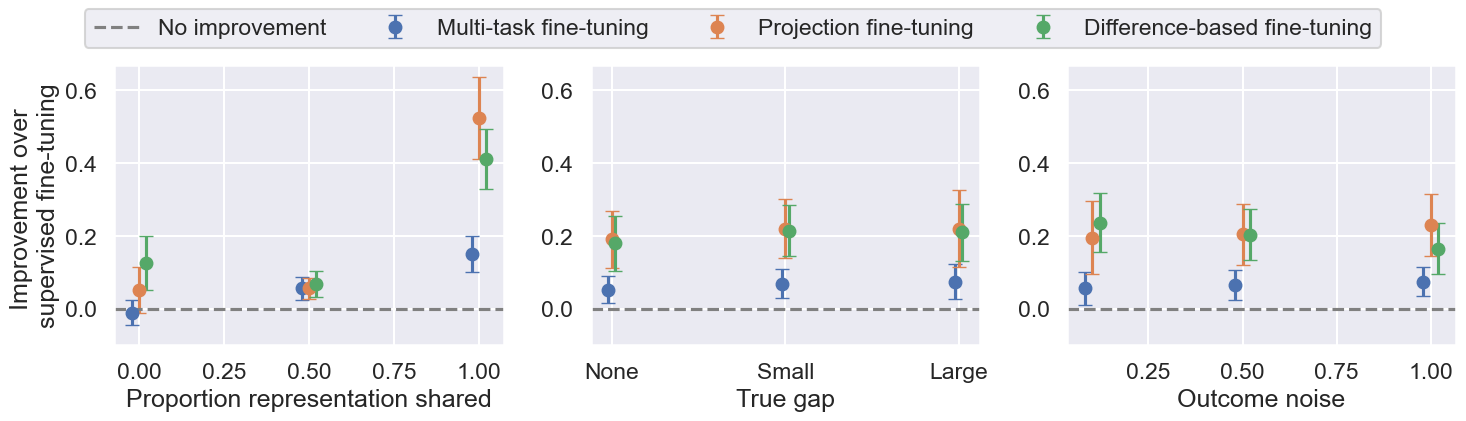

In [156]:

sns.set("talk")
fig, axs = plt.subplots(figsize=(15, 4), nrows=1, ncols=3)
ax1, ax2, ax3 = axs.flatten()

offsets = [-0.02, 0, 0.02]

ylim_min = -0.1
ylim_max = 0.67

category = 'shared_proportion'
for i, method in enumerate(methods):
  means = results[category][method]['mean']
  stds = results[category][method]['std']
  group = results[category][method]['group']
  ax1.errorbar(np.array(group) + offsets[i], means, yerr=2*stds, fmt='o', capsize=5, label=method_to_label[method])
ax1.axhline(0, color='gray', linestyle='--', label='No improvement')
ax1.set_xlabel("Proportion representation shared")
ax1.set_ylabel("Improvement over \nsupervised fine-tuning")
ax1.set_ylim(ylim_min, ylim_max)

category = 'treatment_effect'
for i, method in enumerate(methods):
  means = results[category][method]['mean']
  stds = results[category][method]['std']
  group = results[category][method]['group']
  ax2.errorbar(np.array([0, 1, 2]) + offsets[i], means, yerr=2*stds, fmt='o', capsize=5)#, label=method_to_label[method])
ax2.axhline(0, color='gray', linestyle='--')#, label='No improvement')
ax2.set_xlabel("True gap")
ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(['None', 'Small', 'Large'])
ax2.set_ylim(ylim_min, ylim_max)


category = 'noise_scale'
for i, method in enumerate(methods):
  means = results[category][method]['mean']
  stds = results[category][method]['std']
  group = results[category][method]['group']
  ax3.errorbar(np.array(group) + offsets[i], means, yerr=2*stds, fmt='o', capsize=5)#, label=method_to_label[method])
ax3.axhline(0, color='gray', linestyle='--')#, label='No improvement')
ax3.set_xlabel("Outcome noise")
ax3.set_ylim(ylim_min, ylim_max)

fig.tight_layout()
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4)
# plt.savefig("../figs/semi_synthetic_three_panel.pdf", bbox_inches='tight', dpi=300)

NameError: name 'aipw_methods' is not defined

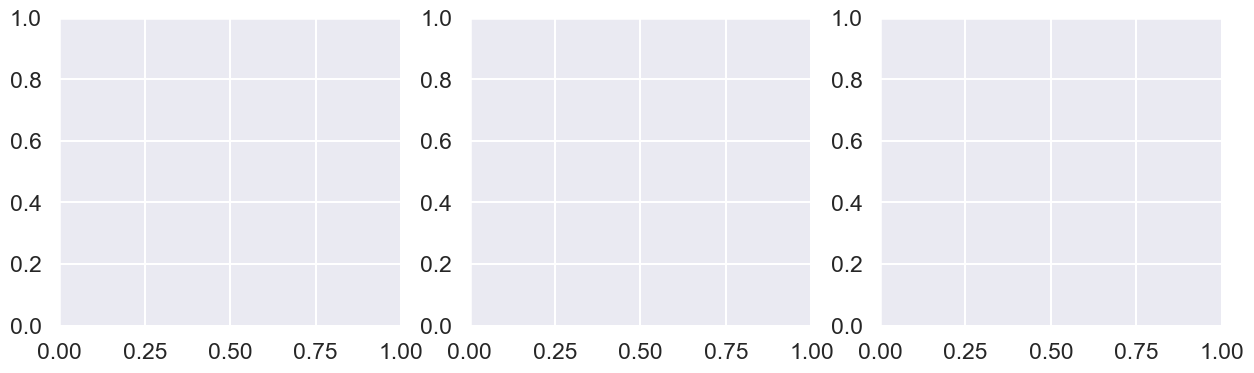

In [157]:

sns.set("talk")
fig, axs = plt.subplots(figsize=(15, 4), nrows=1, ncols=3)
ax1, ax2, ax3 = axs.flatten()

offsets = [-0.02, 0, 0.02]

ylim_min = -0.4
ylim_max = 0.6

category = 'shared_proportion'
for i, method in enumerate(aipw_methods):
  means = results_aipw[category][method]['mean']
  stds = results_aipw[category][method]['std']
  group = results_aipw[category][method]['group']
  ax1.errorbar(np.array(group) + offsets[i], means, yerr=2*stds, fmt='o', capsize=5, label=method_to_label[method])
ax1.axhline(0, color='gray', linestyle='--', label='No improvement')
ax1.set_xlabel("Proportion representation shared")
ax1.set_ylabel("Improvement over \nsupervised fine-tuning")
ax1.set_ylim(ylim_min, ylim_max)

category = 'treatment_effect'
for i, method in enumerate(aipw_methods):
  means = results_aipw[category][method]['mean']
  stds = results_aipw[category][method]['std']
  group = results_aipw[category][method]['group']
  ax2.errorbar(np.array([0, 1, 2]) + offsets[i], means, yerr=2*stds, fmt='o', capsize=5)#, label=method_to_label[method])
ax2.axhline(0, color='gray', linestyle='--')#, label='No improvement')
ax2.set_xlabel("True effect")
ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(['None', 'Small', 'Large'])
ax2.set_ylim(ylim_min, ylim_max)


category = 'noise_scale'
for i, method in enumerate(aipw_methods):
  means = results_aipw[category][method]['mean']
  stds = results_aipw[category][method]['std']
  group = results_aipw[category][method]['group']
  ax3.errorbar(np.array(group) + offsets[i], means, yerr=2*stds, fmt='o', capsize=5)#, label=method_to_label[method])
ax3.axhline(0, color='gray', linestyle='--')#, label='No improvement')
ax3.set_xlabel("Outcome noise")
ax3.set_ylim(ylim_min, ylim_max)

fig.tight_layout()
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4)
# plt.savefig("../figs/semi_synthetic_three_panel_aipw.pdf", bbox_inches='tight', dpi=300)

NameError: name 'r_learner_results' is not defined

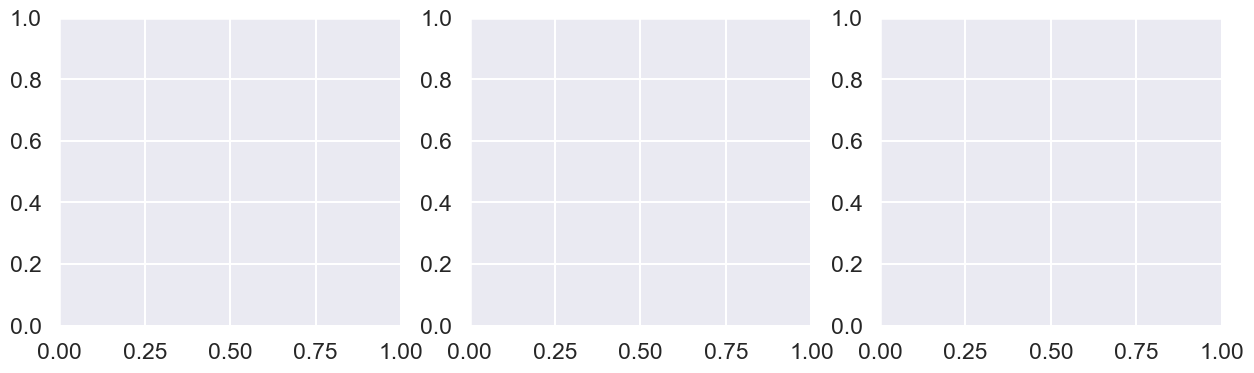

In [171]:

sns.set("talk")
fig, axs = plt.subplots(figsize=(15, 4), nrows=1, ncols=3)
ax1, ax2, ax3 = axs.flatten()

offsets = [-0.05, 0.05]

ylim_min = -0.1
ylim_max = 0.65

category = 'shared_proportion'
for i, method in enumerate([r_learner_results,]):
  means = method[category]['mean']
  stds = method[category]['std']
  group = method[category]['group']
  # label = 'Calibration of differences' if i == 0 else 'Residual objective'
  ax1.errorbar(np.array(group) + offsets[i], means, yerr=stds, fmt='o', capsize=5)#, label=label)
ax1.axhline(0, color='gray', linestyle='--')
ax1.set_xlabel("Proportion representation shared")
ax1.set_ylabel("Average correlation \nbetween R-learner metric \nand estimation error")
ax1.set_ylim(ylim_min, ylim_max)

category = 'treatment_effect'
for i, method in enumerate([r_learner_results]):
  means = method[category]['mean']
  stds = method[category]['std']
  ax2.errorbar(np.array([0, 1, 2]) + offsets[i], means, yerr=stds, fmt='o', capsize=5)#, label=method_to_label[method])
ax2.axhline(0, color='gray', linestyle='--')#, label='No improvement')
ax2.set_xlabel("True effect")
ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(['None', 'Small', 'Large'])
ax2.set_ylim(ylim_min, ylim_max)


category = 'noise_scale'
for i, method in enumerate([r_learner_results]):
  means = method[category]['mean']
  stds = method[category]['std']
  group = method[category]['group']
  ax3.errorbar(np.array(group) + offsets[i], means, yerr=stds, fmt='o', capsize=5)#, label=method_to_label[method])
ax3.axhline(0, color='gray', linestyle='--')#, label='No improvement')
ax3.set_xlabel("Outcome noise")
ax3.set_ylim(ylim_min, ylim_max)

fig.tight_layout()
# plt.savefig("../figs/evaluation_metrics_semi_synthetic.pdf", bbox_inches='tight', dpi=300)